## Install Packages

In [21]:
!pip install scikit-learn pandas numpy matplotlib seaborn datasets huggingface_hub


[notice] A new release of pip is available: 24.2 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


## import the packages

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
from datasets import load_dataset
import re
import string

## SpamAssasin Dataset

In [2]:
dataset = load_dataset("talby/spamassassin")

df = pd.DataFrame(dataset['train'])

print("shape of the dataset:", df.shape)
print("names columns:", df.columns.tolist())
print("distribution of the labels:")
print(df['label'].value_counts())

README.md:   0%|          | 0.00/2.26k [00:00<?, ?B/s]

spamassassin.py:   0%|          | 0.00/6.58k [00:00<?, ?B/s]

dep.py:   0%|          | 0.00/553k [00:00<?, ?B/s]

The repository for talby/spamassassin contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/talby/spamassassin.
You can avoid this prompt in future by passing the argument `trust_remote_code=True`.

Do you wish to run the custom code? [y/N]  y


Generating train split: 0 examples [00:00, ? examples/s]

shape of the dataset: (10749, 3)
names columns: ['label', 'group', 'text']
distribution of the labels:
label
1    6954
0    3795
Name: count, dtype: int64


## Pre-process the data

In [3]:
def preprocess_email(text):
    """Clean and preprocess email text"""
    #lowercase
    text = text.lower()
    
    # no headers
    text = re.sub(r'^(from|to|subject|date|reply-to|message-id):.*$', '', text, flags=re.MULTILINE)
    
    # no html tags
    text = re.sub(r'<[^>]+>', '', text)
    
    # no urls
    text = re.sub(r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\\(\\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', '', text)
    
    # no email addresses
    text = re.sub(r'\S+@\S+', '', text)
    
    # no spacing
    text = re.sub(r'\s+', ' ', text).strip()
    
    return text

# preprocess the text
df['processed_text'] = df['text'].apply(preprocess_email)

In [4]:
df

,label,group,text,processed_text
0,1,easy_ham,"""\n> From: fork-admin@xent.com [mailto:fork-ad...","""\n> from: on behalf of\njames\n> rogers\n\n> ..."
1,1,easy_ham,"""Hi,\n\nOn Sun, 01 Sep 2002 00:05:03 MDT Reg C...","""hi,\n\non sun, 01 sep 2002 00:05:03 mdt reg c..."
2,1,easy_ham,"""On Fri Sep 13 2002 at 02:03, Robert Elz wrote...","""on fri sep 13 2002 at 02:03, robert elz wrote..."
3,1,easy_ham,"""On Thu, 2002-08-29 at 01:06, Matthias Saou wr...","""on thu, 2002-08-29 at 01:06, matthias saou wr..."
4,1,easy_ham,"""Hi, I'm building an rpm for the resin webserv...","""hi, i'm building an rpm for the resin webserv..."
...,...,...,...,...
10744,0,spam_2,"["" \t Preferred Non-Smoker\n \t\n Just what th...","["" \t preferred non-smoker\n \t\n just what th..."
10745,0,spam_2,"""ATTN:SIR/MADAN \n\n ...","""attn:sir/madan \n\n strictly confidential.\n\..."
10746,0,spam_2,"""Dear Subscriber,\n\nIf I could show you a way...","""dear subscriber,\n\nif i could show you a way..."
10747,0,spam_2,"""****Mid-Summer Customer Appreciation SALE!***...","""****mid-summer customer appreciation sale!***..."


In [5]:
# further preprocess the text and remove NaN values
if 'group' in df.columns:
    def map_to_binary(group_label):
        if 'spam' in str(group_label).lower():
            return 1
        elif 'ham' in str(group_label).lower():
            return 0
        else:
            return None  
        
    df['binary_label'] = df['group'].apply(map_to_binary)
    
    if df['binary_label'].isna().sum() > 0:
        unmapped = df[df['binary_label'].isna()]['group'].unique()
else:
    def map_to_binary(label):
        if 'spam' in str(label).lower():
            return 1
        elif 'ham' in str(label).lower():
            return 0
        else:
            return None
    
    df['binary_label'] = df['label'].apply(map_to_binary)
    
    if df['binary_label'].isna().sum() > 0:
        unmapped = df[df['binary_label'].isna()]['label'].unique()


initial_count = len(df)
df = df.dropna(subset=['binary_label'])
final_count = len(df)
df['binary_label'] = df['binary_label'].astype(int)

## split dataset to training, testing

In [6]:
# split the data to X and y
X = df['processed_text']
y = df['binary_label']

#  80% train, 10% validation, 10% test
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=0.1, random_state=42, stratify=y
)

X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.111, random_state=42, stratify=y_temp  # 0.111 * 0.9 ≈ 0.1
)

print(f"\nTraining set: {len(X_train)} samples")
print(f"Validation set: {len(X_val)} samples") 
print(f"Test set: {len(X_test)} samples")


Training set: 8600 samples
Validation set: 1074 samples
Test set: 1075 samples


## Feature Extraction

In [7]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

vectorizer = CountVectorizer(
    max_features=5000,
    stop_words='english',
    min_df=2, 
    max_df=0.95,  
    ngram_range=(1, 2)  
)

X_train_vec = vectorizer.fit_transform(X_train)
X_val_vec = vectorizer.transform(X_val)
X_test_vec = vectorizer.transform(X_test)

print(f"Feature matrix shape: {X_train_vec.shape}")
print(f"Vocabulary size: {len(vectorizer.get_feature_names_out())}")

Feature matrix shape: (8600, 5000)
Vocabulary size: 5000


## Training the model

In [8]:
# Multinomial Naive Bayes
nb_model = MultinomialNB(alpha=1.0)  # Laplace smoothing
nb_model.fit(X_train_vec, y_train)

# predict the validation set
y_val_pred = nb_model.predict(X_val_vec)
y_val_proba = nb_model.predict_proba(X_val_vec)

print("Validation Accuracy:", accuracy_score(y_val, y_val_pred))
print("\nClassification Report:")
print(classification_report(y_val, y_val_pred, target_names=['Ham', 'Spam']))

Validation Accuracy: 0.9683426443202979

Classification Report:
              precision    recall  f1-score   support

         Ham       0.96      0.99      0.98       695
        Spam       0.98      0.93      0.95       379

    accuracy                           0.97      1074
   macro avg       0.97      0.96      0.96      1074
weighted avg       0.97      0.97      0.97      1074



## Uncertainty Quantification

In [9]:
import numpy as np
import pandas as pd

def calculate_entropy(probabilities):
    """Calculate predictive entropy for uncertainty quantification"""
    # Avoid log(0) by adding small epsilon
    epsilon = 1e-15
    probabilities = np.clip(probabilities, epsilon, 1 - epsilon)
    
    # Calculate entropy: H = -sum(p * log(p))
    entropy = -np.sum(probabilities * np.log(probabilities), axis=1)
    return entropy

val_entropy = calculate_entropy(y_val_proba)

val_results = pd.DataFrame({
    'true_label': y_val.values,
    'predicted_label': y_val_pred,
    'spam_probability': y_val_proba[:, 1],
    'entropy': val_entropy
})

print("Entropy statistics:")
print(val_results['entropy'].describe())

entropy_threshold = np.percentile(val_entropy, 75)  # Top 25% entropy
high_entropy_mask = val_entropy > entropy_threshold

print(f"\nHigh-entropy predictions: {np.sum(high_entropy_mask)}")
print(f"Accuracy on high-entropy samples: {accuracy_score(y_val[high_entropy_mask], y_val_pred[high_entropy_mask]):.3f}")
print(f"Accuracy on low-entropy samples: {accuracy_score(y_val[~high_entropy_mask], y_val_pred[~high_entropy_mask]):.3f}")


Entropy statistics:
count    1.074000e+03
mean     1.360530e-02
std      8.152811e-02
min      3.553798e-14
25%      3.553798e-14
50%      3.553798e-14
75%      7.095503e-13
max      6.920352e-01
Name: entropy, dtype: float64

High-entropy predictions: 269
Accuracy on high-entropy samples: 0.900
Accuracy on low-entropy samples: 0.991


## Diagrams about the training and entropy

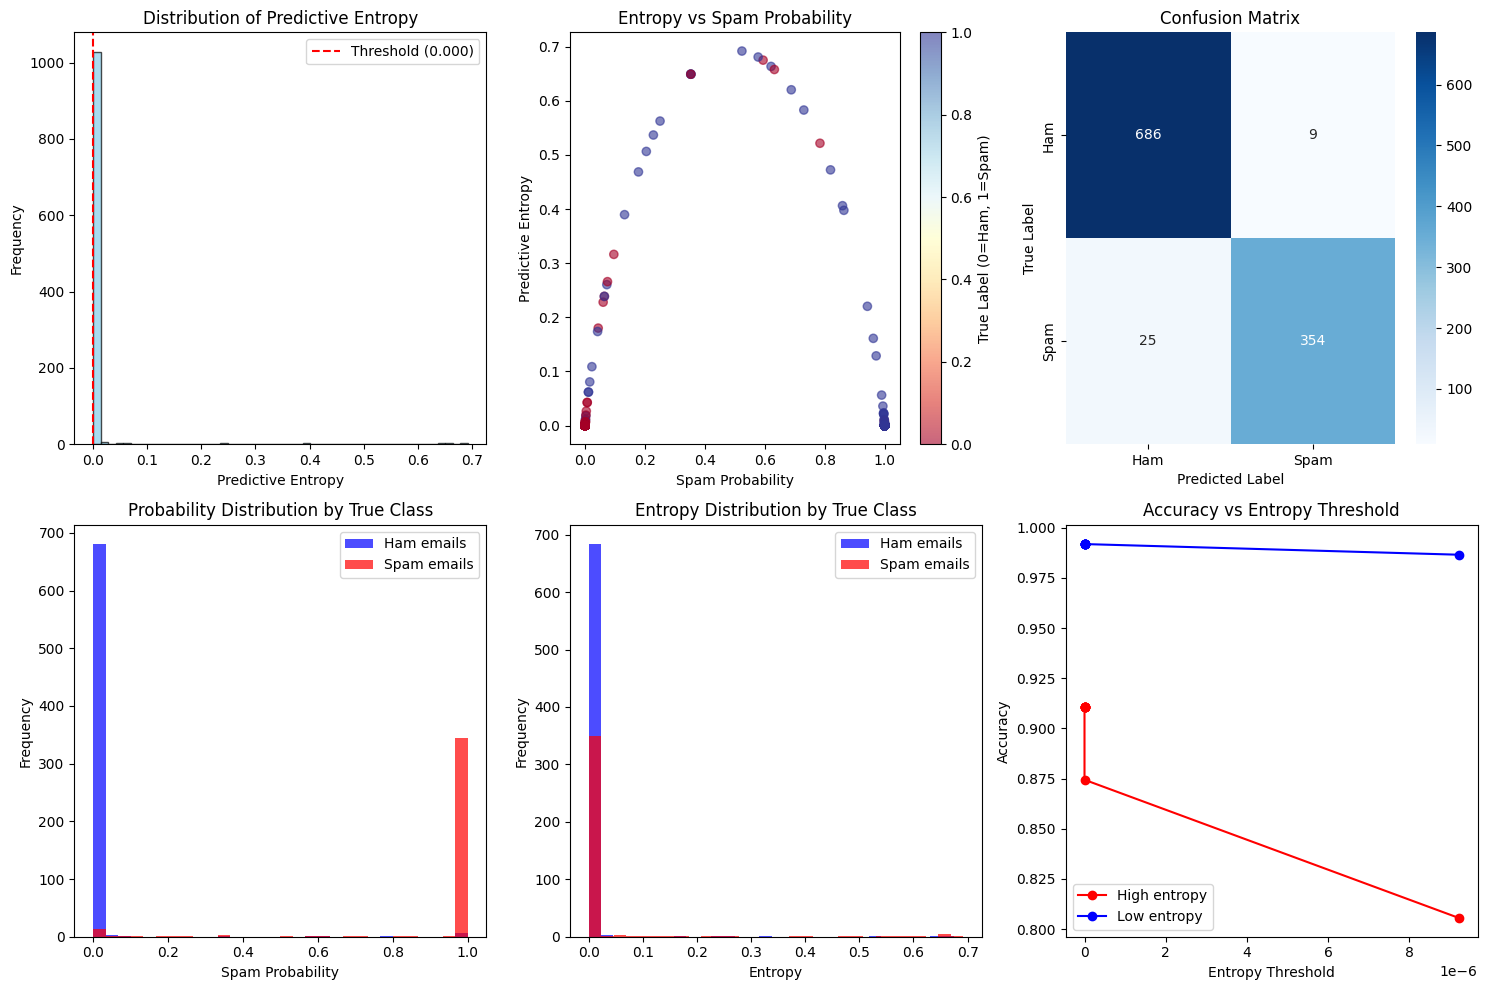

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(15, 10))

# plot 1: entropy distribution
plt.subplot(2, 3, 1)
plt.hist(val_entropy, bins=50, alpha=0.7, color='skyblue', edgecolor='black')
plt.axvline(entropy_threshold, color='red', linestyle='--', label=f'Threshold ({entropy_threshold:.3f})')
plt.xlabel('Predictive Entropy')
plt.ylabel('Frequency')
plt.title('Distribution of Predictive Entropy')
plt.legend()

# p2: entropy and probability
plt.subplot(2, 3, 2)
scatter = plt.scatter(y_val_proba[:, 1], val_entropy, alpha=0.6, c=y_val, cmap='RdYlBu')
plt.xlabel('Spam Probability')
plt.ylabel('Predictive Entropy')
plt.title('Entropy vs Spam Probability')
plt.colorbar(scatter, label='True Label (0=Ham, 1=Spam)')

# p3: confusion matrix
plt.subplot(2, 3, 3)
cm = confusion_matrix(y_val, y_val_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Ham', 'Spam'], yticklabels=['Ham', 'Spam'])
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

# p4: probability distribution by class
plt.subplot(2, 3, 4)
ham_probs = y_val_proba[y_val == 0, 1]  # Spam probability for ham emails
spam_probs = y_val_proba[y_val == 1, 1]  # Spam probability for spam emails

plt.hist(ham_probs, bins=30, alpha=0.7, label='Ham emails', color='blue')
plt.hist(spam_probs, bins=30, alpha=0.7, label='Spam emails', color='red')
plt.xlabel('Spam Probability')
plt.ylabel('Frequency')
plt.title('Probability Distribution by True Class')
plt.legend()

# p5: entropy by true class
plt.subplot(2, 3, 5)
ham_entropy = val_entropy[y_val == 0]
spam_entropy = val_entropy[y_val == 1]

plt.hist(ham_entropy, bins=30, alpha=0.7, label='Ham emails', color='blue')
plt.hist(spam_entropy, bins=30, alpha=0.7, label='Spam emails', color='red')
plt.xlabel('Entropy')
plt.ylabel('Frequency')
plt.title('Entropy Distribution by True Class')
plt.legend()

# p6: accuracy vs entropy threshold
plt.subplot(2, 3, 6)
thresholds = np.percentile(val_entropy, np.arange(10, 100, 10))
accuracies_high = []
accuracies_low = []

for thresh in thresholds:
    high_mask = val_entropy > thresh
    low_mask = val_entropy <= thresh
    
    if np.sum(high_mask) > 0:
        acc_high = accuracy_score(y_val[high_mask], y_val_pred[high_mask])
    else:
        acc_high = 0
    
    if np.sum(low_mask) > 0:
        acc_low = accuracy_score(y_val[low_mask], y_val_pred[low_mask])
    else:
        acc_low = 0
    
    accuracies_high.append(acc_high)
    accuracies_low.append(acc_low)

plt.plot(thresholds, accuracies_high, 'ro-', label='High entropy')
plt.plot(thresholds, accuracies_low, 'bo-', label='Low entropy')
plt.xlabel('Entropy Threshold')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Entropy Threshold')
plt.legend()

plt.tight_layout()
plt.show()


## Confidence Analysis

In [11]:
y_test_pred = nb_model.predict(X_test_vec)
y_test_proba = nb_model.predict_proba(X_test_vec)
test_entropy = calculate_entropy(y_test_proba)

print("Test Set Results:")
print(f"Accuracy: {accuracy_score(y_test, y_test_pred):.3f}")
print("\nClassification Report:")
print(classification_report(y_test, y_test_pred, target_names=['Ham', 'Spam']))

# uncertainty analysis on test set
test_high_entropy_mask = test_entropy > entropy_threshold
print(f"\nUncertainty Analysis:")
print(f"High-entropy predictions: {np.sum(test_high_entropy_mask)} ({np.mean(test_high_entropy_mask)*100:.1f}%)")

# the analysis of the model performance across different confidence levels
def analyze_predictions_by_confidence(y_true, y_pred, probabilities, entropy_scores):
    """Analyze model performance across different confidence levels"""
    confidence_bins = np.array([0.5, 0.7, 0.8, 0.9, 0.95, 1.0])
    max_probs = np.max(probabilities, axis=1)
    
    results = []
    for i in range(len(confidence_bins)-1):
        mask = (max_probs >= confidence_bins[i]) & (max_probs < confidence_bins[i+1])
        if np.sum(mask) > 0:
            acc = accuracy_score(y_true[mask], y_pred[mask])
            avg_entropy = np.mean(entropy_scores[mask])
            count = np.sum(mask)
            results.append({
                'confidence_range': f'{confidence_bins[i]:.2f}-{confidence_bins[i+1]:.2f}',
                'count': count,
                'accuracy': acc,
                'avg_entropy': avg_entropy
            })
    
    return pd.DataFrame(results)

confidence_analysis = analyze_predictions_by_confidence(
    y_test.values, y_test_pred, y_test_proba, test_entropy
)
print("\nPerformance by Confidence Level:")
print(confidence_analysis)

Test Set Results:
Accuracy: 0.968

Classification Report:
              precision    recall  f1-score   support

         Ham       0.96      0.99      0.98       695
        Spam       0.98      0.93      0.95       380

    accuracy                           0.97      1075
   macro avg       0.97      0.96      0.96      1075
weighted avg       0.97      0.97      0.97      1075


Uncertainty Analysis:
High-entropy predictions: 248 (23.1%)

Performance by Confidence Level:
  confidence_range  count  accuracy  avg_entropy
0        0.50-0.70     12  0.333333     0.657599
1        0.70-0.80      7  0.571429     0.538821
2        0.80-0.90      3  0.666667     0.399684
3        0.90-0.95      5  0.600000     0.248531
4        0.95-1.00    226  0.929204     0.006745


## Prediction Function
One example using our spam detector

In [13]:
def predict_spam_with_uncertainty(text, model, vectorizer, entropy_threshold):
    """
    Predict spam probability with uncertainty quantification
    """
    # preprocess text
    processed_text = preprocess_email(text)
    text_vec = vectorizer.transform([processed_text])
    probabilities = model.predict_proba(text_vec)[0]
    prediction = model.predict(text_vec)[0]
    entropy = calculate_entropy(probabilities.reshape(1, -1))[0]
    
    is_ambiguous = entropy > entropy_threshold
    
    return {
        'prediction': 'Spam' if prediction == 1 else 'Ham',
        'spam_probability': probabilities[1],
        'ham_probability': probabilities[0],
        'entropy': entropy,
        'is_ambiguous': is_ambiguous,
        'confidence': 'Low' if is_ambiguous else 'High'
    }

# we test the function with some sample emails
sample_emails = [
    "Congratulations! You've won $1,000,000! Click here now to claim your prize!",
    "Hi John, can we schedule a meeting for tomorrow at 2pm? Thanks, Sarah",
    "URGENT: Your account will be suspended unless you verify your information immediately!"
]

print("Sample predictions:")
for i, email in enumerate(sample_emails, 1):
    result = predict_spam_with_uncertainty(email, nb_model, vectorizer, entropy_threshold)
    print(f"\nEmail {i}: {email[:]}")
    for key, value in result.items():
        if isinstance(value, float):
            print(f"  {key}: {value:.4f}")
        else:
            print(f"  {key}: {value}")


Sample predictions:

Email 1: Congratulations! You've won $1,000,000! Click here now to claim your prize!
  prediction: Spam
  spam_probability: 0.9992
  ham_probability: 0.0008
  entropy: 0.0064
  is_ambiguous: True
  confidence: Low

Email 2: Hi John, can we schedule a meeting for tomorrow at 2pm? Thanks, Sarah
  prediction: Ham
  spam_probability: 0.0158
  ham_probability: 0.9842
  entropy: 0.0814
  is_ambiguous: True
  confidence: Low

Email 3: URGENT: Your account will be suspended unless you verify your information immediately!
  prediction: Spam
  spam_probability: 0.9923
  ham_probability: 0.0077
  entropy: 0.0454
  is_ambiguous: True
  confidence: Low
